# Text Classification Assessment

This assessment is a text classification project where the goal is to classify the genre of a movie based on its characteristics, primarily the text of the plot summarization. You have a training set of data that you will use to identify and create your best predicting model. Then you will use that model to predict the classes of the test set of data. We will compare the performance of your predictions to your classmates using the F1 Score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

The **movie_train.csv** dataset contains information (`Release Year`, `Title`, `Plot`, `Director`, `Cast`) about 10,682 movies and the label of `Genre`. There are 9 different genres in this data set, so this is a multiclass problem. You are expected to primarily use the plot column, but can use the additional columns as you see fit.

After you have identified yoru best performing model, you will create predictions for the test set of data. The test set of data, contains 3,561 movies with all of their information except the `Genre`. 

Below is a list of tasks that you will definitely want to complete for this challenge, but this list is not exhaustive. It does not include any tasds around handling class imbalance or about how to test multiple different models and their tuning parameters, but you should still look at doing those to see if they help you to create a better predictive model.


# Good Luck

In [35]:
from zipfile import ZipFile
import sys
import pandas as pd
import spacy
from spacy.lang.en import English
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gensim
import sklearn 


### Task #1: Perform imports and load the dataset into a pandas DataFrame


In [2]:
df = pd.read_csv("movie_train.csv",index_col=0,)

df.reset_index(drop=False,inplace=True)
df.rename(mapper={'index':'ID'},axis=1,inplace=True)

print(df.shape)

df.head()





(10682, 7)


,ID,Release Year,Title,Plot,Director,Cast,Genre
0,10281,1984,Silent Madness,A computer error leads to the accidental relea...,Simon Nuchtern,"Belinda Montgomery, Viveca Lindfors",horror
1,7341,1960,Desire in the Dust,"Lonnie Wilson (Ken Scott), the son of a sharec...",Robert L. Lippert,"Raymond Burr, Martha Hyer, Joan Bennett",drama
2,10587,1986,On the Edge,"A gaunt, bushy-bearded, 44-year-old Wes Holman...",Rob Nilsson,"Bruce Dern, Pam Grier",drama
3,25495,1988,Ram-Avtar,Ram and Avtar are both childhood best friends....,Sunil Hingorani,"Sunny Deol, Anil Kapoor, Sridevi",drama
4,16607,2013,Machete Kills,Machete Cortez (Danny Trejo) and Sartana River...,Robert Rodriguez,"Danny Trejo, Michelle Rodriguez, Sofía Vergara...",action


### Task #2: Check for missing values:

In [3]:
# Check for NaN values:
df.isna().sum()

ID                0
Release Year      0
Title             0
Plot              0
Director          0
Cast            169
Genre             0
dtype: int64

In [4]:
# Check for whitespace strings (it's OK if there aren't any!):
[df[x].str.isspace().sum() for x in df.columns if df[x].dtype!='int64']








[0, 0, 0, 0, 0]

### Task #3: Remove NaN values:

In [5]:
df.dropna(inplace=True)

In [9]:
df.isna().sum()

ID              0
Release Year    0
Title           0
Plot            0
Director        0
Cast            0
Genre           0
dtype: int64

### Task #4: Take a look at the columns and do some EDA to familiarize yourself with the data. 

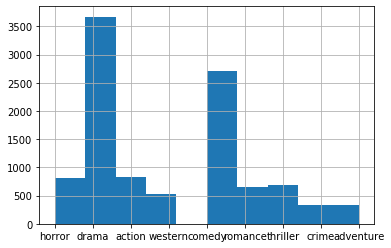

In [6]:
df['Genre'].hist()

In [7]:
df['Genre'].unique()

array(['horror', 'drama', 'action', 'western', 'comedy', 'romance',
       'thriller', 'crime', 'adventure'], dtype=object)

### Task #5: Split the data into train & test sets:

Yes we have a holdout set of the data, but you do not know the genres of that data, so you can't use it to evaluate your models. Therefore you must create your own training and test sets to evaluate your models. 

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=.2,random_state=42)
for train_index, test_index in split.split(df,df['Genre']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]


In [32]:
X_train = strat_train_set['Plot']
y_train = strat_train_set['Genre']

X_test = strat_test_set['Plot']
y_test = strat_test_set['Genre']

### Task #6: Build a pipeline to vectorize the date, then train and fit your models.
You should train multiple types of models and try different combinations of the tuning parameters for each model to obtain the best one. You can use the SKlearn functions of GridSearchCV and Pipeline to help automate this process.


In [26]:
from nltk import sent_tokenize

def Normalizer(text):
    
    def doc_to_sent(docs):
        for doc in docs:
            for sentence in sent_tokenize(doc):
                yield sentence

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    data_words = list(sent_to_words(doc_to_sent(text)))
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
        return texts_out
    data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    return data_lemmatized


In [42]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

bow_vector = CountVectorizer(tokenizer = Normalizer, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = Normalizer)



In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

classifier = LogisticRegression()

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

search_space = [{'classifier': [LogisticRegression()],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(0, 2, 4)},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [100, 200],
                 'classifier__max_features': [3,4]}
        ]

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
scorer = make_scorer(sklearn.metrics.f1_score, average = 'weighted')

# Create grid search 
clf = GridSearchCV(pipe, search_space, cv=3, verbose=2, n_jobs = -1,scoring=scorer)

In [44]:
best_model = clf.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed: 232.2min remaining: 165.8min


ValueError: max_features must be in (0, n_features]

In [ ]:
best_

### Task #7: Run predictions and analyze the results on the test set to identify the best model.  

In [ ]:
# Form a prediction set


In [ ]:
# Report the confusion matrix



In [ ]:
# Print a classification report


In [ ]:
# Print the overall accuracy and F1 score


### Task #8: Refit the model to all of your data and then use that model to predict the holdout set. 

### #9: Save your predictions as a csv file that you will send to the instructional staff for evaluation. 

## Great job!